In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import pytz
import missingno as msno
import altair as alt


[Shift time for TimeCreatedSystemTime to UTC](#timeshift)
[Join machines to events](#machines_events)


In [5]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [6]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [7]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [8]:
def get_compare_chart(in_data, in_col, in_title):
    """
    # Visualize codes by EventName in df_win['EventName'].

    :param in_data:
    :param in_col:
    :param in_title:
    :return:
    """

    count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0: 'count'})
    # Sort order for chart
    count_df2.sort_values('count', ascending=False, inplace=True)
    sort_order = [val for val in count_df2[in_col].unique()]
    out_chart = alt.Chart(count_df2).mark_bar().encode(
        x=alt.X('count:Q'),
        y=alt.Y(in_col + ':N', sort=sort_order),
        tooltip='count:Q'
    ).properties(title=in_title)
    return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
    for eventname in eventname_list:
        current_df = in_df[in_df['EventName'] == eventname]
        out_chart = get_compare_chart(current_df, visualize_attr,
                                      f'Counts of {visualize_attr} types for {eventname} events')
        yield out_chart

In [9]:
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [10]:
# current_chart = next(charts)
# current_chart

In [11]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [12]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [13]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [14]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [15]:
events = pd.concat([df_app, df_win, df_hang])
events.reset_index(inplace=True)
events.dropna(axis=1, how='all', inplace=True) # Dropping columns with nothing in them.
# msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)

In [16]:
len(events)

318796


<a id="machines_events"></a>
# Join events with machines.


In [20]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

In [21]:
# msno.matrix(incs, labels=True, fontsize=8)

In [22]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [23]:
# Join machine name ('Name0') to events by internal date and ClientItemKey (a different, but similar ID for a machine).
# Because events is left, every row will have a TimeCreatedSystemTime.
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'], how='left')

In [24]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

In [25]:
# msno.matrix(machines_events, labels=True, fontsize=8)

In [26]:
# Convert local time values to Central.
def convert_to_cst(df:pd.DataFrame, utc_column_name:str, cst_column_name:str):
    """
    Create a new column in the events dataframe that converts the TimeCreatedSystemTime from UTC to CST.
    (this is necessary because RWB_EFFECTIVE_DATE is in CST)
    """

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

In [27]:
machines_events = convert_to_cst(machines_events, utc_column_name='TimeCreatedSystemTime', cst_column_name='CreatedSystemTime_CST')
machines_events[['TimeCreatedSystemTime', 'CreatedSystemTime_CST']].sample(5) # Check all times are -05:00 or -06:00 from UTC (Daylight Savings Time).

,TimeCreatedSystemTime,CreatedSystemTime_CST
224354,2023-05-15 16:00:09.427000+00:00,2023-05-15 11:00:09.427000-05:00
189817,2023-06-08 05:03:26.490000+00:00,2023-06-08 00:03:26.490000-05:00
272410,2023-02-01 20:42:50.530000+00:00,2023-02-01 14:42:50.530000-06:00
153413,2023-01-03 13:30:36.237000+00:00,2023-01-03 07:30:36.237000-06:00
193135,2023-06-05 12:43:13.227000+00:00,2023-06-05 07:43:13.227000-05:00


In [28]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['CreatedSystemTime_CST_formatted'] = machines_events['CreatedSystemTime_CST'].dt.strftime('%Y-%m-%d')
machines_events['CreatedSystemTime_CST_formatted'][0]

'2023-04-10'

In [29]:
type(pd.to_datetime('2023-07-23 00:01:00').date())

datetime.date


# Join Boot events with machines separately.


In [30]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


In [31]:
df_boot['error_type'] = 'Boot'

In [32]:
# What columns do all four event types have in common?
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [33]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [34]:
# Needs to be a str to join later w/ 'opened_at_formatted'.
# BootID is synonymous with 'TimeCreatedSystemTime'
# since it is the time on the machine when the boot event occurred.
df_boot['BootID_formatted'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [35]:
# Join machine name to boot events, similar to other section.
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])


# Join machines and events with INCs.


In [39]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

In [40]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')

In [41]:
# Join INCs to events on:
# 1. Machine name, and
# 2. The event and the INC both occurred on the same day, using %Y-%m-%d format (YYYY-MM-DD).
incs_merged = machines_events.merge(incs, left_on=['Name0', 'CreatedSystemTime_CST_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')
print(len(incs_merged))

347831


In [42]:
# Drop columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [43]:
# msno.matrix(incs_merged, labels=True, fontsize=7)

In [44]:
# Should be many more. Why only still 4,000?
print(len(incs), "INC rows originally")
print("Now", incs_merged['number'].notnull().sum())

8263 INC rows originally
Now 34625



#### Remove INCs assc. w/ events *after* the INC was already filed.


In [45]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'CreatedSystemTime_CST_formatted',
    'CreatedSystemTime_CST',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]

,CreatedSystemTime_CST_formatted,CreatedSystemTime_CST,opened_at,opened_at_formatted,Name0,configuration_item,number,short_description_NER
74,2023-04-10,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
75,2023-04-10,2023-04-10 15:23:56.900000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
293966,2023-04-10,2023-04-10 12:35:27.050000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death


In [46]:
incs_merged['opened_at_cst_not_utc'] = incs_merged['opened_at'].dt.tz_localize('US/Central')

In [47]:
print("CreatedSystemTime_CST:", incs_merged.loc[74, 'CreatedSystemTime_CST'])
print("INC file time CST:    ", incs_merged.loc[74, 'opened_at_cst_not_utc'])
print("CreatedCST-opened_at: ", incs_merged.loc[74, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_cst_not_utc'])
# This event happened before the INC was filed, at 13:28 UTC vs 16:20 UTC (2h 52m):

CreatedSystemTime_CST: 2023-04-10 08:28:18.740000-05:00
INC file time CST:     2023-04-10 11:20:00-05:00
CreatedCST-opened_at:  -1 days +21:08:18.740000


In [48]:
print("CreatedSystemTime_CST:", incs_merged.loc[75, 'CreatedSystemTime_CST'])
print("INC file time CST:    ", incs_merged.loc[75, 'opened_at_cst_not_utc'])
print("CreatedCST-opened_at: ", incs_merged.loc[75, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_cst_not_utc'])
# This event happened after the INC was filed, at 20:23 UTC vs 16:20 UTC (4h 3m):

CreatedSystemTime_CST: 2023-04-10 15:23:56.900000-05:00
INC file time CST:     2023-04-10 11:20:00-05:00
CreatedCST-opened_at:  0 days 04:03:56.900000


In [49]:
'opened_at_formatted' in incs.columns

True

In [50]:
# Delete INCs across rows when the event occurs before the INC on the same day.
mask = incs_merged['CreatedSystemTime_CST'] >= incs_merged['opened_at_cst_not_utc']
columns_to_set_none = incs.columns
incs_merged.loc[mask, columns_to_set_none] = None

# Looks like no 'CreatedSystemTime_CST value is > 'opened_at'.
incs_merged[incs_merged['number'].notnull()][['CreatedSystemTime_CST', 'opened_at', 'number']]

,CreatedSystemTime_CST,opened_at,number
74,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,INC0515837
502,2023-04-10 07:47:01.750000-05:00,2023-04-10 20:43:00,INC0516099
570,2023-04-10 07:29:33.643000-05:00,2023-04-10 17:39:00,INC0516019
571,2023-04-10 07:51:04.520000-05:00,2023-04-10 17:39:00,INC0516019
572,2023-04-10 10:59:19.490000-05:00,2023-04-10 17:39:00,INC0516019
...,...,...,...
347659,2023-04-11 10:28:02.510000-05:00,2023-04-11 15:52:00,INC0516309
347803,2023-04-13 04:29:30.073000-05:00,2023-04-13 11:37:00,INC0516805
347804,2023-04-13 05:25:58.367000-05:00,2023-04-13 11:37:00,INC0516805
347805,2023-04-13 05:26:29.357000-05:00,2023-04-13 11:37:00,INC0516805


In [51]:
# Check to make sure. Positive = delete. Negative = keep.
(incs_merged['CreatedSystemTime_CST'] - incs_merged['opened_at_cst_not_utc']).dropna()

74       -1 days +21:08:18.740000
75         0 days 04:03:56.900000
502      -1 days +11:04:01.750000
570      -1 days +13:50:33.643000
571      -1 days +14:12:04.520000
                   ...           
347659   -1 days +18:36:02.510000
347803   -1 days +16:52:30.073000
347804   -1 days +17:48:58.367000
347805   -1 days +17:49:29.357000
347806   -1 days +19:47:37.237000
Length: 34625, dtype: timedelta64[ns]

In [52]:
# Timedelta of -1 days (24h) + 16:04 = 8h 04m difference in true time.
incs_merged.loc[502, ['CreatedSystemTime_CST', 'opened_at_cst_not_utc']]

CreatedSystemTime_CST    2023-04-10 07:47:01.750000-05:00
opened_at_cst_not_utc           2023-04-10 20:43:00-05:00
Name: 502, dtype: object


# Join machines and boot events with INCs separately.


In [53]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [54]:
print(incs_boot['number'].notnull().sum(), "Boot INCs")

7472 Boot INCs


In [55]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)

In [56]:
# How many multiple INCs were filed on the same day for a given machine?
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

416


opened_at_formatted  configuration_item
2023-01-03           CHI-L-U33511          2
                     LOE-D-U25294          2
                     MWE-L-U29955          2
2023-01-04           MIL-L-U21470          2
                     MIL-L-U30749          2
                                          ..
2023-07-05           MIL-L-U34247          2
                     TCF-L-U34494          2
2023-07-06           MIL-D-U25226          2
2023-07-10           CHI-L-U34590          2
                     PIT-L-U33237          2
Length: 200, dtype: int64

In [57]:
incs_boot[incs_boot['number'].notnull()]

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,location,category,is_phone,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted
86,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0.0,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
87,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0.0,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
88,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0.0,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
89,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0.0,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
90,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0.0,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528148,1691933,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849976,3,16809497,2023-07-04 09:13:57.197,0,17795,...,{'link': 'https://rwbaird.service-now.com/api/...,citrix,0.0,0.0,Thomson One / Start menu unresponsive in Citrix,ECL-L-U32327,1456.0,2023-07-03,ECL-L-U32327,2023-07-03
1528152,1691938,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849981,3,16811719,2023-07-04 09:14:59.450,0,13923,...,{'link': 'https://rwbaird.service-now.com/api/...,active_directory,0.0,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03
1528153,1691939,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849982,3,16811719,2023-07-04 09:14:59.450,0,15521,...,{'link': 'https://rwbaird.service-now.com/api/...,active_directory,0.0,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03
1528444,1692269,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043850312,3,16813708,2023-07-04 11:57:56.087,0,16158,...,{'link': 'https://rwbaird.service-now.com/api/...,annuity_net,0.0,0.0,User is stating that her entitlements are inco...,HDV-L-U33839,10020.0,2023-07-03,HDV-L-U33839,2023-07-03



# Bring machines, events, and INCs together for both regular events and Boot events.


In [58]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

# Drop all data for May 20th, 2023.
df = df[df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_30755/1261054633.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


In [59]:
len(df[df['error_type'].isin(['Application', 'Hang', 'Windows'])])

344671

In [60]:
len(df[df['error_type'] != 'Boot'])

344671

<Axes: >

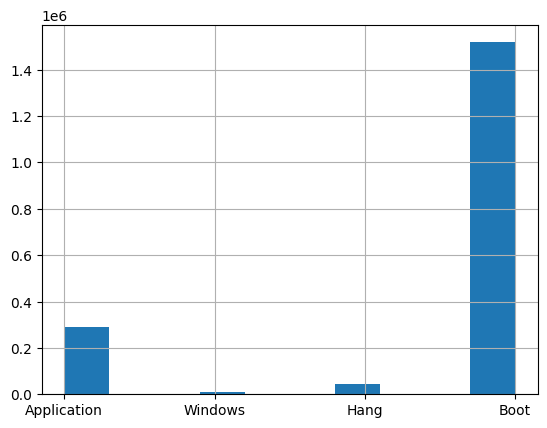

In [61]:
df['error_type'].hist()

In [62]:
print(df.shape)
df.dtypes

(1862856, 170)


level_0                                   int64
index                                   float64
RWB_EVENTRAWRESULTITEM_ID               float64
RWB_ETL_EVENT_DESTINATION_IDENTIFIER      int64
RWB_CREATE_TIMESTAMP                     object
                                         ...   
MachineName                              object
Reason                                   object
param5                                   object
ActionDescription                        object
BootID_formatted                         object
Length: 170, dtype: object

In [63]:
# How many boot events occurred after an INC was filed?
# df[df['error_type'] == 'Boot']['BootID'] - df[df['error_type'] == 'Boot']['opened_at_cst_not_utc']


# Create 'num_events' feature.


In [64]:
'CreatedSystemTime_CST_formatted' in list(df.columns)

True

In [65]:
# Because 'TimeCreatedSystemTime' never exists in 'df_boot',
# 'CreatedSystemTime_CST_formatted' will always be pd.NaT for Boot events,
# because it is unique to the regular events only.
df[df['error_type'] == 'Boot']['CreatedSystemTime_CST'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns, America/Chicago]

In [66]:
# Create the events feature by grouping by ClientItemKey and the TimeCreatedSystemTime CST date column,
# and get the count of events for each machine each day.
# Boot events excluded by default on basis of the .groupby() columns.

# num_events = df.groupby(['RWB_EFFECTIVE_DATE', 'ClientItemKey']).agg('size').reset_index().rename(columns={0:'events'})
num_events = df[df['error_type'] != 'Boot'].groupby(['ClientItemKey', 'CreatedSystemTime_CST_formatted']).agg('size').reset_index().rename(columns={0:'events'})
num_events

,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16783564,2023-03-13,1
1,16783564,2023-04-03,2
2,16783835,2023-01-10,1
3,16783835,2023-01-20,1
4,16783835,2023-02-10,1
...,...,...,...
188461,16819018,2023-05-15,1
188462,16819018,2023-06-28,1
188463,16819018,2023-06-30,3
188464,16819021,2023-06-30,1


<Axes: >

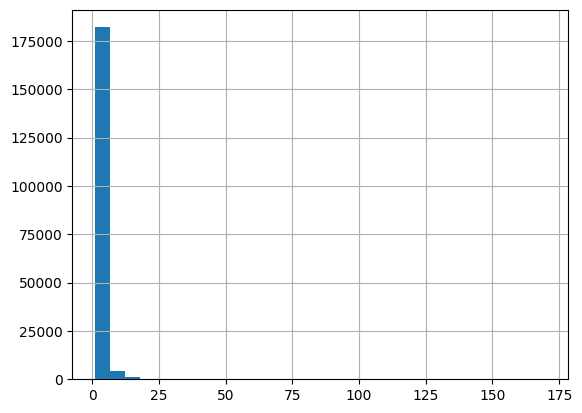

In [67]:
num_events['events'].hist(bins=30)

In [ ]:
check_this_df = pd.read_parquet('../do_not_commit/FeatureDatasets/num_events.pq')
print(check_this_df['events'].sum())
check_this_df

In [382]:
# Export the result to parquet and save to blob storage.
num_events.to_parquet('../do_not_commit/FeatureDatasets/num_events.pq')


# Create 'num_events_incs' feature.


In [69]:
# 'opened_at_formatted' was wiped for all events (rows) after an INC was filed on same day
# in the join machines + events + incs section. If no value exists for any events
# after an INC was filed, subsetting with .notnull() should give us what we need.

num_events_inc = df[
    (df['error_type'] != 'Boot') &
    (df['opened_at_formatted'].notnull())
].groupby(['ClientItemKey', 'CreatedSystemTime_CST_formatted']).agg('size').reset_index().rename(columns={0:'events'})
num_events_inc

,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16787905,2023-01-23,2
1,16787905,2023-05-01,1
2,16787935,2023-03-06,2
3,16787935,2023-03-30,1
4,16787935,2023-06-06,1
...,...,...,...
3182,16818798,2023-06-27,1
3183,16818818,2023-06-20,1
3184,16818828,2023-06-27,1
3185,16818878,2023-06-27,3


In [70]:
# 'CreatedSystemTime_CST' is in CST, 'opened_at' is in UTC, a difference of 6 hours.
df[(df['ClientItemKey'] == 16790461) & (df['CreatedSystemTime_CST_formatted'] == '2023-02-22')][['CreatedSystemTime_CST', 'opened_at']]

,CreatedSystemTime_CST,opened_at
313428,2023-02-22 15:10:37.167000-06:00,2023-02-22 21:31:00
313429,2023-02-22 15:11:38.777000-06:00,2023-02-22 21:31:00
313430,2023-02-22 15:12:22.523000-06:00,2023-02-22 21:31:00
313431,2023-02-22 15:12:47.290000-06:00,2023-02-22 21:31:00
313432,2023-02-22 15:16:09.427000-06:00,2023-02-22 21:31:00
313433,2023-02-22 15:24:32.457000-06:00,2023-02-22 21:31:00
313434,2023-02-22 15:29:28.760000-06:00,2023-02-22 21:31:00
313435,2023-02-22 15:31:15.080000-06:00,2023-02-22 21:31:00
313436,2023-02-22 15:36:11.057000-06:00,2023-02-22 21:31:00
313437,2023-02-22 15:36:30.607000-06:00,2023-02-22 21:31:00


<Axes: >

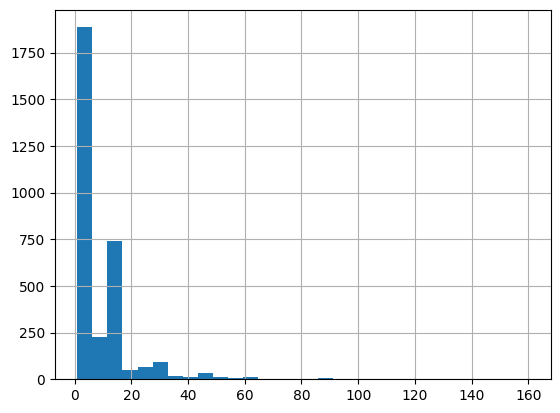

In [71]:
num_events_inc['events'].hist(bins=30)

In [ ]:
check_this_df = pd.read_parquet('../do_not_commit/FeatureDatasets/num_events_inc.pq')
print(check_this_df['events'].sum())
check_this_df

In [387]:
# Export the result to parquet and save to blob storage.
num_events_inc.to_parquet('../do_not_commit/FeatureDatasets/num_events_inc.pq')


#### How many INCs contain direct reference to BSOD?


In [73]:
df['short_description_NER'].unique()

array([nan, 'URGENT| Repeated Blue Screen of Death', None, ...,
       "Computer was n't working", 'Fidessa + TradeWeb install',
       'Thomson One / Start menu unresponsive in Citrix'], dtype=object)

In [74]:
# How many short descriptions talk about BSODs?
len(df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

62

<Axes: >

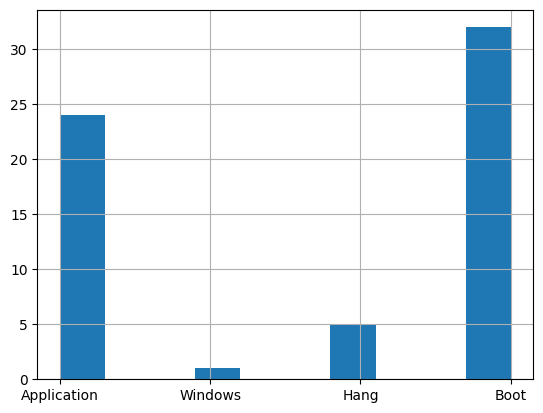

In [75]:
# What is the frequency of each error type for BSOD tickets?
df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [76]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'Combined_Application', 'Combined_dll', 'Combined_Exception']]

,error_type,Combined_Application,Combined_dll,Combined_Exception
74,Application,powershell.exe,BIOSIntf.dll,c0000005
9241,Application,powershell.exe,BIOSIntf.dll,c0000005
25444,Application,powershell.exe,BIOSIntf.dll,c0000005
40854,Application,IntelAudioService.exe,ControlModule.dll,c0000005
46572,Application,powershell.exe,BIOSIntf.dll,c0000005
...,...,...,...,...
1803359,Boot,NaN,NaN,0x0
1822166,Boot,NaN,NaN,0x0
1825446,Boot,NaN,NaN,0x0
1834536,Boot,NaN,NaN,0x0


In [77]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_30755/2969922424.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']


74                          powershell.exe
9241                        powershell.exe
25444                       powershell.exe
40854                IntelAudioService.exe
46572                       powershell.exe
47768                       powershell.exe
48260                 RtkAudUService64.exe
51414                          OUTLOOK.EXE
65019                       powershell.exe
68297                              dwm.exe
75345                       powershell.exe
81693                IntelAudioService.exe
83858                       powershell.exe
84542                       powershell.exe
89704                       WavesSvc64.exe
90057                       powershell.exe
93884     svchost.exe_BrokerInfrastructure
97969                       powershell.exe
108751                      powershell.exe
119084                      powershell.exe
169853                RtkAudUService64.exe
207614                      powershell.exe
245688                      powershell.exe
291586     

In [79]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_30755/120276331.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


402455                              BSOD- No stop code error
489120                                                  BSOD
502157                                                  BSOD
510451                  Plugging in headphones prompted BSOD
1192667    BSOD at Startup- Stop Code WHEA- uncorrectable...
1203529    Received the blue screen of death <CARDINAL> t...
1207316                                                 BSOD
1234722                             Laptop BSOD'd 5/10/20223
1245577    Laptop Overheating, Blue Screen Crashing- Unit...
1250894    Repeated Blue Screen Error: Device did not sta...
1264105    BSOD at Startup- Get stuck at Dell logo before...
1269083                        Blue Screen Crashes on laptop
1269206                  Laptop Blue Screening Every Morning
1289926                                        BSOD- Startup
1294146                                Laptop BSOD on U30366
1295014               BSOD- Device did not startup correctly
1302842                 


#### What is the distribution of FaultApplicationName among INCs?


In [80]:
df_check = df[df['error_type'] == 'Application']

In [81]:
df_check['Combined_Application'].value_counts()

Combined_Application
powershell.exe               75110
EXCEL.EXE                    23807
Acrobat.exe                  22042
WavesSvc64.exe               16361
RtkAudUService64.exe         15082
                             ...  
AdobeCaptivate.exe               1
DtsDebugHost.exe                 1
svchost.exe_SensorService        1
Login.exe                        1
iupdate.exe                      1
Name: count, Length: 736, dtype: int64


#### What is the distribution of modules among INCs?


In [82]:
df_check['Combined_dll'].value_counts()

Combined_dll
BIOSIntf.dll            74986
KERNELBASE.dll          44684
ntdll.dll               26611
WavesSvc64.exe          16278
RtkAudUService64.exe    14951
                        ...  
v_slkdynhj.dll              1
l_cgakubqt.dll              1
f_wnobyade.dll              1
v_pifauomw.dll              1
u_lwawedzn.dll              1
Name: count, Length: 18061, dtype: int64


#### Which exception codes are most common among INCs?


In [83]:
df_check[['Combined_Application', 'Combined_Exception']].value_counts()

Combined_Application       Combined_Exception
powershell.exe             c0000005              74992
WavesSvc64.exe             c0000005              16325
RtkAudUService64.exe       c0000005              14968
Acrobat.exe                c0000005              10053
                           e06d7363               9732
                                                 ...  
SSFolderPrev.exe           c0000005                  1
SSHPdf2Jpg.exe             c0000094                  1
SSMS-Setup-ENU.exe         c00000fd                  1
Sage.NA.AT_AU.SysTray.exe  c000041d                  1
zt.exe                     c0000005                  1
Name: count, Length: 1702, dtype: int64

### Create Incident category and faulting applications figure for report

In [120]:

df = incs_merged
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)


df = df.query("""`number`.str.contains('INC', na=False, case=False, regex=False)""")

s2 = df[~pd.isnull(df['Combined_Application'])]

def get_compare_chart(in_data, in_col, x_axis_title, y_axis_title, in_title):
    """
    Visualize the top n most common faulting applications 
    """

    count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0: 'count'})
    # Sort order for chart
    count_df2.sort_values('count', ascending=False, inplace=True)
    count_df2 = count_df2.iloc[:10]
    sort_order = [val for val in count_df2[in_col].unique()]
    out_chart = alt.Chart(count_df2).mark_bar().encode(
        x=alt.X('count:Q', axis=alt.Axis(title=x_axis_title)),
        y=alt.Y(in_col + ':N',axis=alt.Axis(title=y_axis_title), sort=sort_order),
        tooltip='count:Q'
    ).properties(title=in_title)
    return out_chart

get_compare_chart(s2, 'Combined_Application', 'No. of Events', 'Faulting Application Name', '')

alt.Chart(...)

In [121]:
### CATEGORY ### 

duplicates = df.duplicated(['number'], keep='first')
s = df[~duplicates]

s = s[~pd.isnull(s['category'])]

get_compare_chart(s, 'category', 'No. of Incidents', 'Incident Category', '')

alt.Chart(...)

In [122]:
### SUBCATEGORY ### 
get_compare_chart(s, 'subcategory',  'No. Incidents', 'Incident Subcategory', '')

alt.Chart(...)